# Final Project

Project by Aditya Subramanian

This project used a kaggle dataset. A link to the dataset is in the Data Download/Preprocessing Section.

##Introduction

According to the cdc, heart attacks are the leading cause of death for almost all demographics in the United States. In fact, "one person dies every 34 seconds from cardiovascular". Furthermore, the monetary cost of heart disease was estimated to be about 229 billion dollars from 2017 to 2018! [CDC](https://www.cdc.gov/heartdisease/facts.htm#:~:text=In%20the%20United%20States%2C%20someone,heart%20attack%20every%2040%20seconds.&text=Every%20year%2C%20about%20805%2C000%20people,States%20have%20a%20heart%20attack.&text=Of%20these%2C,are%20a%20first%20heart%20attack)

In order to both save lives and money, it is important to be able to understand how to better predict which people are more likely to obtain a heart attack in order to zone in on those that need the most help. Furthermore, it is also important to give a qualitative, simplified analysis of which general properties/characteristics of a person contribute to a high heart attack probability. In this report, I intend to shed some light both on a method of predicting the likelihood of heart attack for an individual and the general qualities an individual may exhibit (e.g. perceived health, environmental factors, etc.) so that a layperson can obtain a general feeling about their likelihood of a heart attack and (if possible) take measures to improve their quality of life.

## Data Download / Preprocessing

The goal of Data Analysis/Preprocessing is to download the necessary packages and obtain and curate the data.

In this section, the main goal is to import necessary libraries from [pandas](https://pandas.pydata.org/), [matplotlib](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html), [sklearn](https://scikit-learn.org/stable/), and [scipy](https://docs.scipy.org/doc/scipy/reference/stats.html).

In [2]:
#Importing Modules/Packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import kstest
from sklearn.model_selection import cross_validate

The next main goal is to obtain the data. This dataset was obtained from [kaggle](https://www.kaggle.com/datasets/alexteboul/heart-disease-health-indicators-dataset). Simply download the csv file in the same directory as the jupyter notebook and use pd.read_csv() to convert the csv to a pandas dataframe.

In [3]:
#Obtaining Data
df = pd.read_csv('heart_disease_health_indicators_BRFSS2015.csv')
print(df.head())
print(df.columns)

   HeartDiseaseorAttack  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0                   0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1                   0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2                   0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3                   0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4                   0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   Diabetes  PhysActivity  Fruits  ...  AnyHealthcare  NoDocbcCost  GenHlth  \
0       0.0           0.0     0.0  ...            1.0          0.0      5.0   
1       0.0           1.0     0.0  ...            0.0          1.0      3.0   
2       0.0           0.0     1.0  ...            1.0          1.0      5.0   
3       0.0           1.0     1.0  ...            1.0          0.0      2.0   
4       0.0           1.0     1.0  ...            1.0          0.0      2.0   

   MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  I

The next goal is to clean up the data and get it ready for analysis.

Dealing with NaN values:
NaN values are important to remove, since they often do not allow for analysis on the dataset. In order to remove the NaN values, I simply deleted all the rows associated with NaN values using df.dropna(), since there were very few rows with NaN values, I could afford to remove this data given the size of my dataset. However, in cases where this approach is not ideal, it may be necessary to [replace NaNs using rolling averages of nearby datapoints](https://www.geeksforgeeks.org/how-to-fill-nan-values-with-mean-in-pandas/) or use other methods.

Undersampling from Negative Datapoints:
Given that the number of datapoints which did not have a heart attack is much larger than the number of datapoints which did have a heart attack, it is important to either reduce the number of negative datapoints by removing data using [undersampling](https://www.mastersindatascience.org/learning/statistics-data-science/undersampling/#:~:text=Undersampling%20is%20a%20technique%20to,information%20from%20originally%20imbalanced%20datasets.) or to increase the number of positive datapoints by copying positive data using [oversampling](https://www.pewresearch.org/fact-tank/2016/10/25/oversampling-is-used-to-study-small-groups-not-bias-poll-results/#:~:text=Oversampling%20is%20the%20practice%20of,they%20do%20in%20the%20population.). Otherwise, regression/classification algorithms may be biased towards the negative population. I chose undersampling, since the amount of data I had was quite large, and since I also had issues with the amount of time regression models would take to train and validate.

In [4]:
#Examing Dataset and Removing NaNs
i = 0
for column in df.columns:
    i = i + int(df[column].isna().sum())
print("Total Number of NaN Values: " + str(i))
for column in df.columns:
    #Checking if data is not a float
    df[column].apply(lambda x: print("Not a float") if (not isinstance(x, float)) else None)
print("Total Number of Columns: " + str(len(df.columns)))
print("Total Number of Datapoints: " + str(len(df)))
df.dropna(inplace=True)
#Undersampling
print("Total Number of Positive Datapoints: " + str(len(df[df['HeartDiseaseorAttack']==1.0])))
print("Total Number of Negative Datapoints: " + str(len(df[df['HeartDiseaseorAttack']==0.0])))
negative_rows = df[df['HeartDiseaseorAttack'] == 0.0]
negative_rows = negative_rows.sample(n=len(df[df['HeartDiseaseorAttack']==1.0]))
positive_rows = df[df['HeartDiseaseorAttack'] == 1.0]
i = 0
for column in df.columns:
    #Checking if value is a NaN value.
    i = i + int(df[column].isna().sum())
print("Total Number of NaN Values: " + str(i))
df = negative_rows.append(positive_rows)
print("Total Number of Datapoints After Undersampling: " + str(len(df)))
print("Total Number of Positive Datapoints After Undersampling: " + str(len(df[df['HeartDiseaseorAttack']==1.0])))
print("Total Number of Negative Datapoints After Undersampling: " + str(len(df[df['HeartDiseaseorAttack']==0.0])))


Total Number of NaN Values: 0
Total Number of Columns: 22
Total Number of Datapoints: 253680
Total Number of Positive Datapoints: 23893
Total Number of Negative Datapoints: 229787
Total Number of NaN Values: 0
Total Number of Datapoints After Undersampling: 47786
Total Number of Positive Datapoints After Undersampling: 23893
Total Number of Negative Datapoints After Undersampling: 23893


##Data Analysis

The main goal of data analysis is to provide a new, interesting way to slice the data into categories and to visualize the correlations between different variables. Data Analysis should be present in the rest of this project, but the following section is dedicated purely to data analysis.

Plotting Function:
This section of code was used to plot certain columns of the dataframe with respect to each other. The majority of plots used for data analysis were bar plots, since the majority of data is categorical in nature.

In [5]:
#Function Definitions for Plotting Correlations
def bar_plot_func(dataframe, x_column, y_column, title, x_label, y_label, x_list = ['DNE'], bool=False,colore='blue'):
    output_list = []
    input_list = dataframe[x_column].unique()
    input_list.sort()
    #Finding average y value for each x value and appending to output list
    for input in input_list:
        average= dataframe.groupby(x_column).get_group(input)[y_column].mean()
        output_list.append(average)
    for i in range(len(input_list)):
        input_list[i] = (input_list[i].astype(str))
    #Dealing with Categorical Data
    if x_list != ['DNE']:
      input_list = x_list
    #Plotting Data
    fig1, ax1 = plt.subplots()
    ax1.bar(input_list, output_list, color=colore)
    ax1.set_title(title)
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)
        



This section of code both analyses the correlations between the perceptions of individuals about their own health and the probability of getting a heart attack and compresses the perceived physical, mental, and general health columns into one perceived health column.

Plotting Correlations Between Perceived Health and Heart Disease:
In order to plot the correlations, I used the bar_plot_fun method defined above. Based on the graphs alone, a lack of perceived physical health and perceived mental health have positive correlations with heart disease. In other words, if an individual believes that they have poor mental/physical health, they are more likely to get a heart attack. Furthermore, the perceived physical and mental health columns were found to be highly positively correlated. A lower perception of mental health correlates with a lower perception of physical health and vice versa.

Principle Component Analysis:
[PCA](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) is a useful tool for removing dependencies in input datasets. This means that the new basis created is orthogonal, which implies that each basis vector describes entirely the variance along its axis. With this tool, it is possible to combine multiple input columns into one column representing the majority of the variance of the input. In the code below, I first normalized input columns using the StandardScaler().fit_transform() function before creating a pca object. I then obtained the principle component column and added it to my new pca_df dataframe. 

For this project, I am grouping columns of similar correlation parities (positive/negative correlation) with respect to heart disease and grouping columns of similar connotations. For example, perceived mental and physical health both correlate positively with heart attacks and share similar meanings (i.e. they fall under the general category of how an individual perceives their health). This process will be repeated in the code blocks below!


array([[0.49571169, 0.62382653, 0.60424364]])

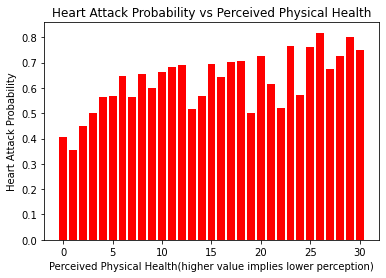

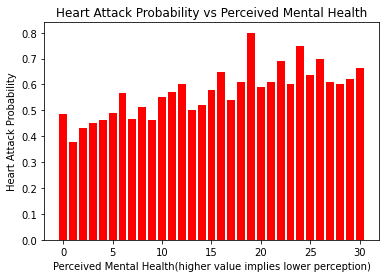

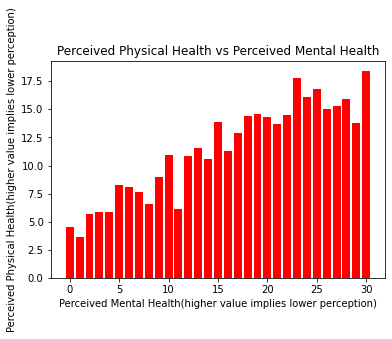

In [6]:
#Plotting Correlations Between Perceived Health and Heart Disease
df.rename(columns={'HeartDiseaseorAttack': "Heart Disease/Attack", 'PhysHlth': "Perceived Physical Health", 'MentHlth': "Perceived Mental Health", 'GenHlth': 'Perceived General Health'}, inplace=True)
pca_df = pd.DataFrame()
title = "Heart Attack Probability vs Perceived Physical Health"
x_label = "Perceived Physical Health(higher value implies lower perception)"
y_label = "Heart Attack Probability"
bar_plot_func(df, 'Perceived Physical Health', 'Heart Disease/Attack', title, x_label, y_label,colore='red')
title = "Heart Attack Probability vs Perceived Mental Health"
x_label = "Perceived Mental Health(higher value implies lower perception)"
y_label = "Heart Attack Probability"
bar_plot_func(df, 'Perceived Mental Health', 'Heart Disease/Attack', title, x_label, y_label,colore='red')
title = "Perceived Physical Health vs Perceived Mental Health"
x_label = "Perceived Mental Health(higher value implies lower perception)"
y_label = "Perceived Physical Health(higher value implies lower perception)"
bar_plot_func(df, 'Perceived Mental Health', 'Perceived Physical Health', title, x_label, y_label,colore='red')

#PCA component analysis.
x = df[['Perceived Mental Health','Perceived Physical Health','Perceived General Health']]
#Scaling the data for PCA analysis
x = StandardScaler().fit_transform(x)
#Creating PCA object and adding dataframe column
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['Perceived Health Component'])
pca_df['Perceived Health Component'] = principalDf['Perceived Health Component']
pca.explained_variance_
pca.components_

This section of code both analyses the correlations between the individuals' good/bad habits and the probability of getting heart disease and compresses the good/bad habits columns into two good and bad habit columns.

Plotting Correlations Between Habits and Heart Disease:
The method for plotting the correlation is the same as the previous code block. 

When plotting the good habits such as diet (eating fruits/vegetables) and exercise, it was found that exercise and a proper diet decreased the probability of getting heart disease. With exercise especially, doing exercise resulted in a 24% reduction in the likelihood of heart disease (this is still not foolproof, as there could be correlations between exercise and other variables causing this reduction, not exercise itself). 

When plotting the bad habits such as alcohol consumption and smoking, it was found that drinking alcohol supposedly substantially decreases the probability of heart disease, while smoking substantially increases the probability of getting heart disease. The unintuitive negative correlation between alcohol consumption and heart disease will be touched on when income is introduced. Furthermore, smoking is highly correlated with alcohol consumption. In other words, a person who smokes is also far more likely to drink alcohol.

Principle Component Analysis: In the code below, two separate pca objects were created, one for good habits and one for bad habits. For the good habits, one principle component was created, combining exercise and diet into a good habits column. For the bad habits, two principle components were created, since smoking and alcohol consumption are diametrically opposed with regards to their correlations with heart disease probability. Again, as stated in the previous code block, columns which fell into similar categories were grouped together, however, since alcohol and smoking have different correlation parities with respect to heart disease, it was important to distinguish between them by adding a separate bad habits PCA axis. In your projects, either use PCA on the entire column set to produce purely mutually orthogonal axes if you do not care to understand the meaning behing the axes and simply want a better regression model, or use reasoning to decide which columns should be grouped together.

Heart Attack Probability With Exercise: 0.452635938701852
Heart Attack Probability Without Exercise: 0.6144879862700229
26.339334728189247 less likely to get a heart attack with exercise


array([[ 0.70710678,  0.70710678],
       [ 0.70710678, -0.70710678]])

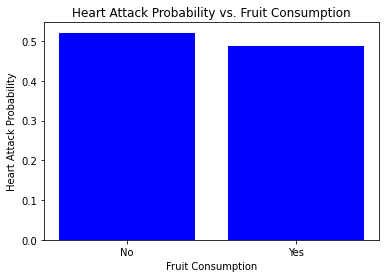

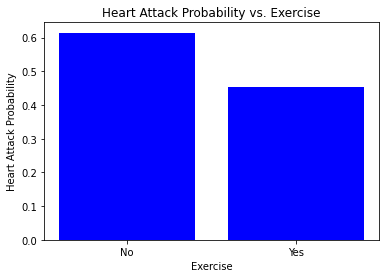

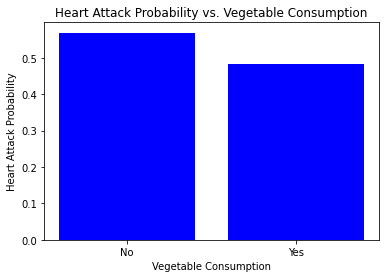

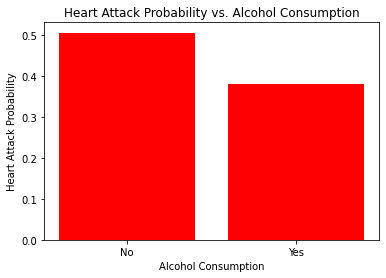

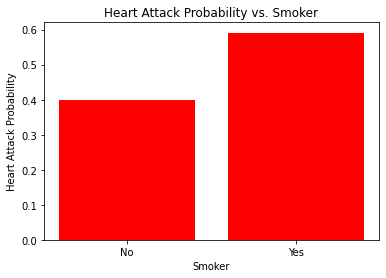

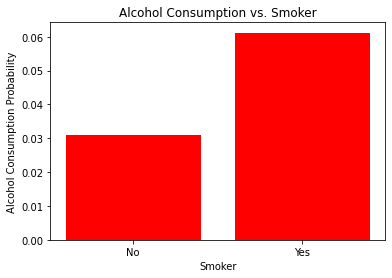

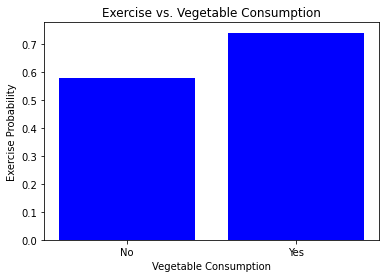

In [7]:
#Correlations Between Habits and Heart Disease
fruit = "Fruit Consumption"
physactivity = "Exercise"
veggies = "Vegetable Consumption"
hvyAlcoholConsump = "Alcohol Consumption"
smoker = "Smoker"
vs = " vs. "
heart_attack = "Heart Attack Probability"
#Renaming dataframe columns
df.rename(columns = {'Fruits': fruit,'PhysActivity': physactivity, 'Veggies': veggies, 'HvyAlcoholConsump': hvyAlcoholConsump, 'Smoker': smoker}, inplace=True)
parameter_list = [fruit, physactivity, veggies, hvyAlcoholConsump, smoker]
#Plotting each parameter with Heart Disease/Attack Probability
for i in range(len(parameter_list)):
    title = heart_attack + vs + parameter_list[i]
    x_label = parameter_list[i]
    y_label = heart_attack
    if parameter_list[i] in [fruit, physactivity, veggies]:
      bar_plot_func(df, parameter_list[i], 'Heart Disease/Attack', title, x_label, y_label, x_list = ["No", "Yes"])
    else:
      bar_plot_func(df, parameter_list[i], 'Heart Disease/Attack', title, x_label, y_label, x_list = ["No", "Yes"], colore='red')

heart_attack_prob_exercise = df.groupby(physactivity).get_group(1.0)['Heart Disease/Attack'].mean()
heart_attack_prob_without_exercise = df.groupby(physactivity).get_group(0.0)['Heart Disease/Attack'].mean()

#Percent Difference in Probability of a Heart Attack With and Without Exercise
print('Heart Attack Probability With Exercise: ' + str(heart_attack_prob_exercise))
print('Heart Attack Probability Without Exercise: ' + str(heart_attack_prob_without_exercise))

print(str((1-heart_attack_prob_exercise/heart_attack_prob_without_exercise)*100) + " less likely to get a heart attack with exercise")

#Graphs of Correlations between Bad Habits
title = hvyAlcoholConsump + vs + smoker
x_label = smoker
y_label = hvyAlcoholConsump + ' Probability'
bar_plot_func(df, smoker, hvyAlcoholConsump, title, x_label, y_label, x_list = ["No", "Yes"], colore ='red')

#Graphs of Correlations between Exercise and Vegetables
title = physactivity + vs + veggies
x_label = veggies
y_label = physactivity + ' Probability'
bar_plot_func(df, veggies, physactivity, title, x_label, y_label, x_list = ["No", "Yes"])

#Creating PCA Columns For Both Good and Bad Habits
x = df[[fruit, physactivity, veggies]]
#Scaling input data
x = StandardScaler().fit_transform(x)
#Creating PCA object and adding column
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['Good Habits Component'])
pca_df['Good Habits Component'] = principalDf['Good Habits Component']
pca.explained_variance_
pca.components_
#Repeating the steps above
x = df[[hvyAlcoholConsump, smoker]]
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['Bad Habit Component1', 'Bad Habit Component2'])
pca_df['Bad Habit Component1'] = principalDf['Bad Habit Component1']
pca_df['Bad Habit Component2'] = principalDf['Bad Habit Component2']
pca.explained_variance_
pca.components_

This section of code both analyses the correlations between the individuals' environment and the probability of getting a heart attack and compresses the environmental columns into two columns, one for status (income and education) and the other for age and sex (intrinsic qualities of the individual).

Plotting Correlations Between Environmental Factors and Heart Disease: The method for plotting the correlation is the same as the previous code blocks.

When plotting the environmental factors such as sex, age, education, and income, it was found that a higher income and education is correlated with a lower heart attack probability, while a higher age is correlated with a higher heart attack probability. Females are less likely to get heart disease than males as well, as can be seen from the Heart Disease vs Sex graph. Furthermore, education is positively correlated with income (i.e a person with a higher education is more likely to have a higher income and vice versa). More interestingly, alcohol consumption is highly correlated with income. One potential exponential explanation for this is that since individuals need money to buy alcohol, individuals who do drink should have a reasonable income. This *could* give an understanding for why alcohol consumption is associated with a lower risk of heart disease, since an alcoholic individual is more likely to have money, and a higher income reduces the risk of heart disease. Unfortunately, for this project, this claim will not be tested.

Principle Component Analysis: For this project, two separate principle components were generated, one for the intrinsic qualities of the individual (i.e. sex and age), and another for external environmental factors such as income and education. Again, as can be seen from the previous blocks, I am grouping columns of similar correlation parity and connotation with each other.

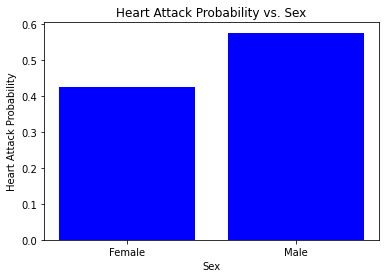

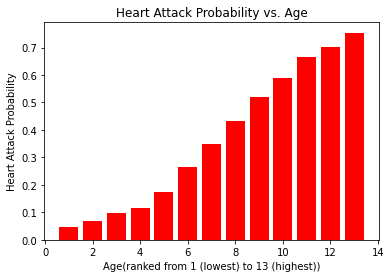

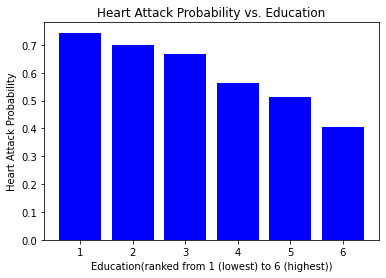

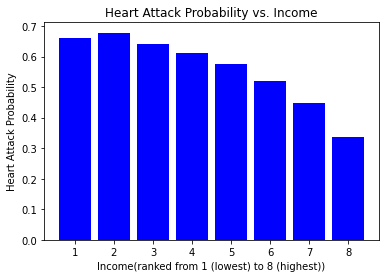

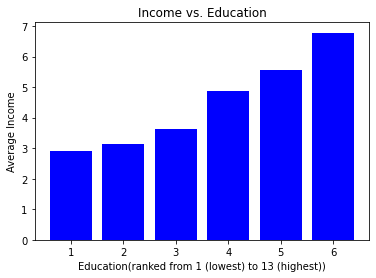

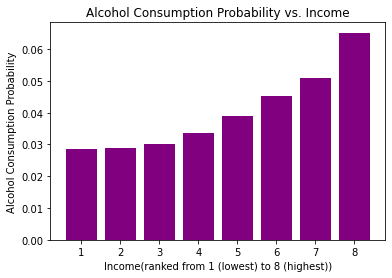

In [8]:
#Correlation Between Heart Attacks/Heard Disease and Environmental Factors
heart_attack = "Heart Attack Probability"
parameter_list = ['Sex', 'Age', 'Education', 'Income']
#Plotting Correlations Between Environmental Factors and Heart Disease/Attack Probability
for i in range(len(parameter_list)):
    title = heart_attack + vs + parameter_list[i]
    x_label = parameter_list[i]
    y_label = heart_attack
    if i == 0:
        bar_plot_func(df, 'Sex', 'Heart Disease/Attack', title, x_label, y_label, x_list = ["Female", "Male"])
    elif i == 1:
        bar_plot_func(df, 'Age', 'Heart Disease/Attack', title, (x_label + '(ranked from 1 (lowest) to 13 (highest))'), y_label, colore = 'red')
    elif i == 2:
        bar_plot_func(df, 'Education', 'Heart Disease/Attack', title, (x_label + '(ranked from 1 (lowest) to 6 (highest))'), y_label)
    else:
        bar_plot_func(df, 'Income', 'Heart Disease/Attack', title, x_label +'(ranked from 1 (lowest) to 8 (highest))', y_label)

#Plotting Average Income vs Education
title = parameter_list[3] + vs + parameter_list[2]
x_label = parameter_list[2] + '(ranked from 1 (lowest) to 13 (highest))'
y_label = 'Average ' + parameter_list[3]
bar_plot_func(df, parameter_list[2], parameter_list[3], title, x_label, y_label)

#Plotting Alcohol Consumption Probability vs Income
title = 'Alcohol Consumption Probability' + vs + parameter_list[3]
x_label = parameter_list[3] + '(ranked from 1 (lowest) to 8 (highest))'
y_label = 'Alcohol Consumption' + ' Probability'
bar_plot_func(df, parameter_list[3], hvyAlcoholConsump, title, x_label, y_label, colore='purple')

#PCA Analysis: a repeat of the steps in the previous code block
x = df[parameter_list[0:2]]
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['Sex And Age Environmental Factor'])
pca_df['Sex And Age Environmental Factor'] = principalDf['Sex And Age Environmental Factor']
pca.explained_variance_
pca.components_
x = df[parameter_list[2:]]
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['Income And Education Environmental Factor'])
pca_df['Income And Education Environmental Factor'] = principalDf['Income And Education Environmental Factor']

This section of code both analyses the correlations between the individuals' ailments and the probability of getting a heart attack and compresses the ailment columns into one column.

Plotting Correlations Between  and Heart Disease: The method for plotting the correlation is the same as the previous code blocks.

When plotting the correlation between ailments such as High Blood Pressure, High Cholesterol, Difficulty Walking, and the Cholesterol Check Test, it was found that all of the above increase the risk of heart disease significantly. Interestingly, BMI increased the chance of heart disease for low BMIs as well as high BMIs. For example, those with BMIs lower or higher than 20 were more at risk of heart disease.

Principle Component Analysis: For this part of the project, one principle component was created describing the general ailment status of an individual (combining BMI and all the other columns seen below).

array([[0.57380467, 0.39969589, 0.49664404, 0.21508508, 0.46698448]])

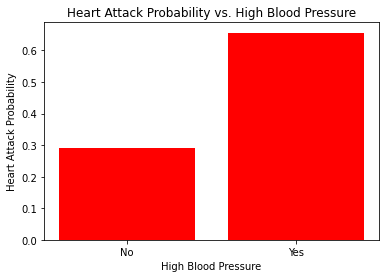

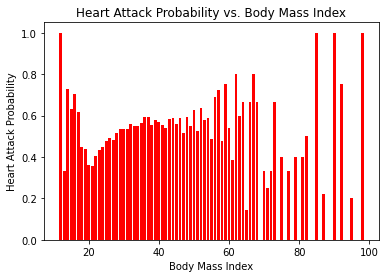

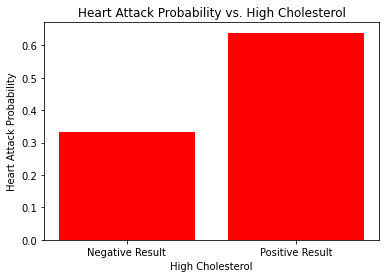

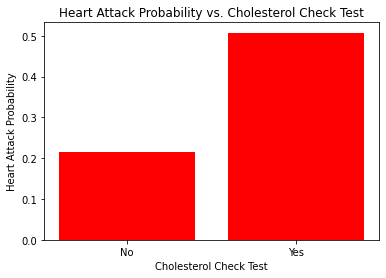

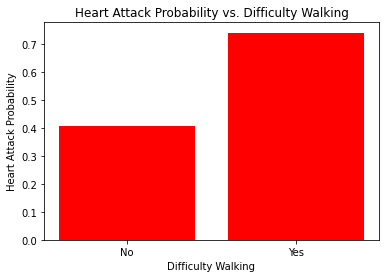

In [9]:
#Correlation Between Heart Attack Probability and Ailments
bmi = 'Body Mass Index'
bp = 'High Blood Pressure'
chl = 'High Cholesterol'
diffwalk = 'Difficulty Walking'
chlchk = 'Cholesterol Check Test'

#Renaming dataframe columns
df.rename(columns={'HighBP': bp, 'HighChol': chl, 'CholCheck': chlchk, 'BMI': bmi, 'DiffWalk': diffwalk}, inplace=True)
parameter_list = [bp, bmi, chl, chlchk, diffwalk]

#Plotting Ailments and Heart Attack Probability
for i in range(len(parameter_list)):
    title = heart_attack + vs + parameter_list[i]
    x_label = parameter_list[i]
    y_label = heart_attack
    if i == 2:
      bar_plot_func(df, parameter_list[i], 'Heart Disease/Attack', title, x_label, y_label, x_list = ['Negative Result', 'Positive Result'], colore='red')
    elif len(df[parameter_list[i]].unique()) == 2:
      bar_plot_func(df, parameter_list[i], 'Heart Disease/Attack', title, x_label, y_label, x_list = ['No', 'Yes'], colore='red')
    else:
      bar_plot_func(df, parameter_list[i], 'Heart Disease/Attack', title, x_label, y_label, colore='red')
#PCA
x = df[parameter_list]
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['Actual Health'])
pca_df['Actual Health'] = principalDf['Actual Health']
pca.explained_variance_
pca.components_


This section of code both analyses the correlations between the individuals' access to doctors and the probability of getting a heart attack and compresses the columns into one column using PCA.

Plotting Correlations Between  and Heart Disease: The method for plotting the correlation is the same as the previous code blocks.

The Access to Doctors column does not have a significant correlation with heart disease. However, individuals without access to doctors do tend to have a slightly higher probability of heart disease.

Principle Component Analysis: For this part of the project, one PCA was created combining the Health Care and Access to Doctors Columns.

array([[ 0.70710678, -0.70710678]])

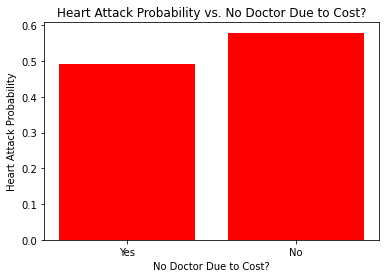

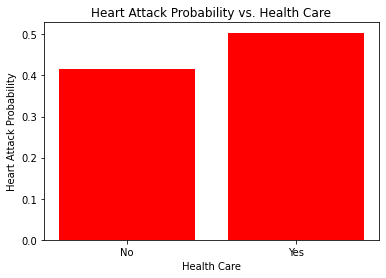

In [10]:
#Correlation Between Heart Attack Probability and Access to Doctors
cost = 'No Doctor Due to Cost?'
healthcare = 'Health Care'
df.rename(columns={'NoDocbcCost': cost, 'AnyHealthcare': healthcare}, inplace=True)
parameter_list = [cost, healthcare]
#Plotting Heart Attack Probability vs Access to Doctors
for i in range(len(parameter_list)):
    title = heart_attack + vs + parameter_list[i]
    x_label = parameter_list[i]
    y_label = heart_attack
    if i == 0:
      bar_plot_func(df, parameter_list[i], 'Heart Disease/Attack', title, x_label, y_label, ["Yes", "No"], colore='red')
    else:
      bar_plot_func(df, parameter_list[i], 'Heart Disease/Attack', title, x_label, y_label, ["No", "Yes"], colore='red')
#PCA
x = df[parameter_list]
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['Access to Doctors'])
pca_df['Access to Doctors'] = principalDf['Access to Doctors']
pca.explained_variance_
pca.components_

##Model Analysis

In this part of the project, the main goal is to produce models which will be used to predict whether a person is likely to have heart disease.

The first main goal is to separate the data into input and output datasets. In this section of code, the input data is placed in the X dataframe, while the output data is placed in the y dataframe. Keep in mind that the PCA columns will not be fed into the vanilla random forest regression model.

In [11]:
#Separating df into Input and Output data
y = df['Heart Disease/Attack']
X = df
X = X.drop('Heart Disease/Attack', axis = 'columns')

The next main goal is to produce a vanilla random forest algorithm which takes in raw data and predicts the output data well. Using [sklearn](https://scikit-learn.org/stable/), I was able to produce a [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor) model. This model is an [ensemble of decision trees]((https://towardsdatascience.com/a-quick-and-dirty-guide-to-random-forest-regression-52ca0af157f8)) (which themselves are models which produce answers based on categorizing data by input attributes). This model has two [hyperparameters](https://towardsdatascience.com/parameters-and-hyperparameters-aa609601a9ac): the number of decision trees(n_estimators) and the depth of each decision tree(max_depth). There were other models which could have been used, such as XGBoost (this is must faster, since it can be run on a GPU). However, these models would have required [the cuML package](https://docs.rapids.ai/api/cuml/stable/api.html), which is not compatible with the cross_val_score function from sklearn below.

The next main goal is to produce a test framework for the model, for which I used [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) from sklearn. This function uses k-fold cross validation to separate the test and training sets into 10 groups in order to create and test a model without overfitting. The type of error I used to test the model was negative mean squared error. 

The next main goal is to find the best hyperparameters which, given the test framework, produces the best results. In order to find a reasonably good set of hyperparameters, it is important to loop through a large portion of the possible hyperparameters and find the subset which produced the best results. Due to time constraints, it was not possible to search through a large hyperparameter space. Other ways for finding the best hyperparameters include running a regression algorithm on the hyperparameters themselves or using methods such as [gridSearch or parameter optimization](https://scikit-learn.org/stable/modules/grid_search.html). However, I found that it would be better to cover a wide region of the hyperparameter space while incrementing the hyperparameters by two or four instead of one to save time.



In [12]:
#Creating the Model, Running, and Testing!
random = RandomForestRegressor(n_estimators=1, max_depth = 1)
scores = cross_val_score(random, X, y, cv=10,scoring = 'neg_mean_squared_error')
best_n_estimator1 = 1
best_max_depth1 = 1
best_error1 = sum(scores)/10
error_list = []
#Looping through hyperparameter and finding the best error.
for i in range(10,50,2):
    for j in range(3,12,4):
        #Creating the regression model
        random = RandomForestRegressor(n_estimators=i, max_depth = j)
        #Running cross validation with neg ative mean squared error
        scores = cross_val_score(random, X, y, cv=10,scoring = 'neg_mean_squared_error')
        error_list.append(sum(scores)/10)
        #Checking if this run is the best run so far
        if(best_error1 < sum(scores)/10):
            best_error1 = sum(scores)/10
            best_n_estimator1 = i
            best_max_depth1 = j
print("Best n estimator(number of decision trees) for random forest: " + str(best_n_estimator1))
print("Best max depth for random forest: " + str(best_max_depth1))
print("Random Forest error: "+ str(best_error1))
print(len(X))

Best n estimator(number of decision trees) for random forest: 48
Best max depth for random forest: 11
Random Forest error: -0.18904306840390003
47786


The next goal for this project is to create a random forest model using the PCA data obtained in the data analysis section. The steps are the same as above. Instead of providing the df columns as input, I simply provided the pca_df columns as input.

In [13]:
y = df['Heart Disease/Attack']
X = pca_df
#Creating, Running, and Testing the Model
random = RandomForestRegressor(n_estimators=1, max_depth = 1)
scores = cross_val_score(random, X, y, cv=10,scoring = 'neg_mean_squared_error')
best_n_estimator2 = 1
best_max_depth2 = 1
best_error2 = sum(scores)/10
pca_error_list = []
#Looping through hyperparameters and finding the best error
for i in range(10,50, 2):
    for j in range(3,12, 4):
        #Creating the regression model
        random = RandomForestRegressor(n_estimators=i, max_depth = j)
        #Running cross validation
        scores = cross_val_score(random, X, y, cv=10,scoring = 'neg_mean_squared_error')
        pca_error_list.append(sum(scores)/10)
        #Checking if this model is the best so far
        if(best_error2 < sum(scores)/10):
            best_error2 = sum(scores)/10
            best_n_estimator2 = i
            best_max_depth2 = j
print("Best n estimator(number of decision trees) for random forest: " + str(best_n_estimator2))
print("Best max depth for random forest: " + str(best_max_depth2))
print("Random Forest PCA error: "+ str(best_error2))

Best n estimator(number of decision trees) for random forest: 42
Best max depth for random forest: 7
Random Forest PCA error: -0.19630216126602237


As can be seen, while the vanilla random forest model does perform better overall, (with a negative mean regression which is closer to zero than the PCA model), the PCA model requires a smaller number of trees and a smaller depth to get reasonably good results! 

##Hypothesis Testing

In this part of the project, it is important to test the hypothesis for which this report was created for. In my case, the hypothesis would be: can a human understanding of the dataset be used to obtain a reasonably good estimate for the general factors contributing to heart disease? Given the data about the vanilla and pca random forest regressors obtained above, it is possible to answer this question.

The first main goal is to properly curate the data obtained above which hypothesis testing will test on. In my case, I [normalized the error](https://www.statology.org/normalize-data-between-0-and-1/) for each run since I want to test whether the variances are significantly different as well. 

In [14]:
import copy
#Function for normalizing data between 0 and 1
def normalize_0_to_1(arr):
  arr1 = arr
  min = arr1[0]
  #Subtrac all elements by the minimum value
  for i in range(len(arr1)):
    if min > arr1[i]:
      min = arr1[i]
  for i in range(len(arr1)):
    arr1[i] -= min
  max = arr[0]
  #Divide by the max so the array ranges from 0 to 1
  for i in range(len(arr1)):
    if max < arr1[i]:
      max = arr1[i]
  for i in range(len(arr1)):
    arr1[i] = arr1[i]/max
  return arr1
#Negating negative mean squared error and Normalizing data.      
error_list_abs = copy.deepcopy(error_list)
pca_error_list_abs = copy.deepcopy(pca_error_list)
for i in range(len(error_list)):
  error_list_abs[i] = -error_list_abs[i]
  pca_error_list_abs[i] = -pca_error_list_abs[i]
error_list_norm_abs = normalize_0_to_1(copy.deepcopy(error_list_abs))
pca_error_list_norm_abs = normalize_0_to_1(copy.deepcopy(pca_error_list_abs))



The next main goal is to test the hypothesis:

In order to perform hypothesis testing, I used the [kolmogorov smirnov hypothesis test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html). This hypothesis test is useful for non-parametric distributions (i.e. not Gaussian). It essentially takes two sampled distributions and states whether or not they come from the same population. A [P-value](https://towardsdatascience.com/p-values-explained-by-data-scientist-f40a746cfc8) < 0.05 indicates that the two distributions are not the same, while a P-value > 0.05 indicates the opposite.

Do the vanilla and PCA random forest regressors have errors which correspond to the same distributions? In this case, the answer is no for the normal distribution and yes for the unnormalized distributions. Therefore, the human intuition does give a reasonable approximation of the data, but the distribution of data is not the same between the normal and pca'd models.

In [15]:
#perform Kolmogorov-Smirnov test On Normalized And Unnormalize Data
ksTestResult = kstest(error_list_norm_abs, pca_error_list_norm_abs)
print("Hypothesis Testing Normalized Data: " + str(ksTestResult))
ksTestResult = kstest(error_list_abs, pca_error_list_abs)
print("Hypothesis Testing Unnormalized Data: " + str(ksTestResult))
print(error_list_norm_abs)
print(error_list_abs)

Hypothesis Testing Normalized Data: KstestResult(statistic=0.25, pvalue=0.046660870723173625)
Hypothesis Testing Unnormalized Data: KstestResult(statistic=0.6666666666666666, pvalue=6.098898740329411e-13)
[0.9982318930178204, 0.06922879452486204, 0.09511000572150567, 0.9838562341548307, 0.05986755020352253, 0.0929602308486156, 0.9811055172754671, 0.039919146086760005, 0.07440931452347167, 1.0, 0.05259489472400906, 0.05548003967711251, 0.9762632197459374, 0.05653172235745191, 0.052909602024362984, 0.9669237342476298, 0.05846296387301392, 0.041334840574186314, 0.9809111221919244, 0.05292299912801826, 0.05458509521086827, 0.986867412073033, 0.05831691326468386, 0.03610940555795759, 0.9654312316007252, 0.04380749166335336, 0.0351961711098906, 0.9557166311910313, 0.04557029484624061, 0.028843487154980946, 0.9732325063479246, 0.046760295651879856, 0.025217637376522706, 0.974750891769038, 0.054803367074104284, 0.034150771035645136, 0.9732558621032946, 0.04434390383550313, 0.012531622294585173

##Further Analysis

This section of the project focuses on looking at the most important categories for both the vanilla and PCA's random forest regressions. The code for plotting the relative importances can be found [here](https://stackoverflow.com/questions/44101458/random-forest-feature-importance-chart-using-python).

In this section, I plotted the relative significant axes for both the vanilla random forest and the PCA random forest. Unfortunately, as can be seen by the graphs, good habits and bad habits play almost no role in predicting whether or not an individual will get heart disease. Of all the habits, the most important is smoking. Smokers exhibit a higher risk for getting heart disease, even if they exercise and eat right. Removing bad habits is far more important according to the model than good habits (i.e. a person who smokes and exercises is worse off than an individual which does neither).

The most important factor is High Blood Pressure and other Health measurements. The next most important factors are sex and age followed by perceived general health and bmi.

Feature importances for vanilla model: [0.2384644  0.04103841 0.00356746 0.05824745 0.01652221 0.03380008
 0.01349209 0.00780198 0.0083075  0.00751188 0.00480365 0.00403508
 0.00615893 0.17372541 0.02388867 0.03093928 0.01484403 0.04574049
 0.21060147 0.02073173 0.03577782]


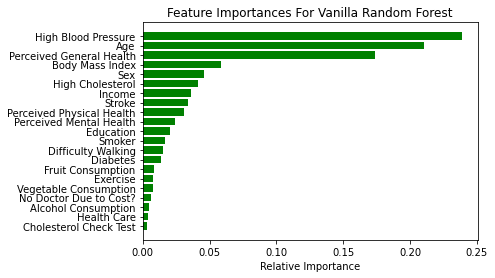

Feature importances for pca model: [0.17147841 0.00389235 0.0027408  0.01016058 0.31313129 0.02774347
 0.46858901 0.0022641 ]


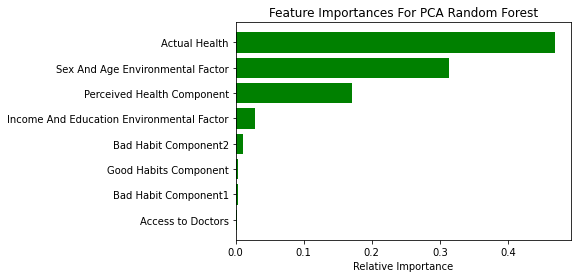

In [16]:
X = df
X = X.drop('Heart Disease/Attack', axis = 'columns')
#Finding Most Important Components for Vanilla Model
vanilla_model = RandomForestRegressor(n_estimators= best_n_estimator1, max_depth = best_max_depth1)
#Getting model from cross validate function
scores = cross_validate(vanilla_model, X, y, cv=10,scoring = 'neg_mean_squared_error', return_estimator = True)
vanilla_model = scores['estimator'][0]
print("Feature importances for vanilla model: " + str(vanilla_model.feature_importances_))
features = X.columns
#Ranking features by importance
importances = vanilla_model.feature_importances_
#Sorting by importance
indices = np.argsort(importances)
#Plotting
plt.title('Feature Importances For Vanilla Random Forest')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
#Finding Most Important Components for Vanilla Model
X = pca_df
pca_model = RandomForestRegressor(n_estimators= best_n_estimator2, max_depth = best_max_depth2)
scores = cross_validate(pca_model, X, y, cv=10,scoring = 'neg_mean_squared_error', return_estimator=True)
#Getting model from cross_validate function
pca_model = scores['estimator'][0]
print("Feature importances for pca model: " + str(pca_model.feature_importances_))
features = X.columns
#Ranking features by importance
importances = pca_model.feature_importances_
#Sorting by importance
indices = np.argsort(importances)
#Plotting
plt.title('Feature Importances For PCA Random Forest')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


##Conclusion

With this project, completed, you should have learned about a variety of topics in data science.

I first covered data extraction, curation, undersampling. I then moved on to PCA and showed how to divide up data into orthogonal components. I then covered how to use the random forest regressor algorithm and 10 fold cross validation to produce fitted models which accurately predict the data. Finally, I covered how to properly complete hypothesis testing and compared two distributions (vanilla and pca error distributions) before plotting the most important categories used by the random forest algorithms.

With regards to this project, a human intuition does provide a reasonably good estimation of the important information required to predict heart disease probability! 

However, unfortunately, the good and bad habit columns do not play a significant role with respect to the environmental factors as shown above. There are two potential methods of viewing this outcome. Firstly, this likely indicates that there is very little that can be done about risks of heart disease outside of environmental factors (the most significant of which is to not smoke). Secondly, good and bad habits could potentially be correlated with factors the regression model weights highly such as education, income, actual health, and perceived health (i.e. perceived health and other factors could potentially have some (causal?) roots in good habits). 

Ironically, the group of people which need healthcare the most are very likely those who are predisposed to not obtain it (i.e. the poor and the uneducated), while the rich and the educated, who are less likely to get heart disease, will be prioritized simply by their nature. Still, exercise, a good diet, and the removal of bad habits will reduce the likelihood of getting heart disease.